In [ ]:
import os

imdb_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [ ]:
texts[0]

"This movie is a prime example of squandering great resources in a film. You've got future SNL and SCTV stars in their prime, such as John Candy, Chevy Chase, Laraine Newman, Al Franken,Tom Davis and Joe Flaherty essentially making 70 minutes of coarse, uninspired fart and racist jokes. The concept of a network from the future subverting society could have really been taken to some interesting extremes, but instead right out the gate, makes a lame, juvenile proctology joke and stays in that vein of humor the whole way.Seek out the earlier and much more subversive and witty Groove Tube or the later, hilarious Kentucky Fried Movie. This movie is only for those who want to see a time capsule of bad 70's sketch comedy movies."

### 데이터 토큰화

이전 절에서 소개한 개념을 사용해 텍스트를 벡터로 만들고 훈련 세트와 검증 세트로 나누겠습니다. 사전 훈련된 단어 임베딩은 훈련 데이터가 부족한 문제에 특히 유용합니다(그렇지 않으면 문제에 특화된 임베딩이 훨씬 성능이 좋습니다). 그래서 다음과 같이 훈련 데이터를 처음 200개의 샘플로 제한합니다. 이 모델은 200개의 샘플을 학습한 후에 영화 리뷰를 분류할 것입니다.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100개 단어 이후는 버립니다
training_samples = 200  # 훈련 샘플은 200개입니다
validation_samples = 10000  # 검증 샘플은 10,000개입니다
max_words = 10000  # 데이터셋에서 가장 빈도 높은 10,000개의 단어만 사용합니다

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

# 데이터를 훈련 세트와 검증 세트로 분할합니다.
# 샘플이 순서대로 있기 때문에 (부정 샘플이 모두 나온 후에 긍정 샘플이 옵니다) 
# 먼저 데이터를 섞습니다.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


### GloVe 단어 임베딩 내려받기

https://nlp.stanford.edu/projects/glove 에서 2014년 영문 위키피디아를 사용해 사전에 계산된 임베딩을 내려받습니다. 이 파일의 이름은 glove.6B.zip이고 압축 파일 크기는 823MB입니다. 400,000만개의 단어(또는 단어가 아닌 토큰)에 대한 100차원의 임베딩 벡터를 포함하고 있습니다. datasets 폴더 아래에 파일 압축을 해제합니다.


In [ ]:
import os
import numpy as np

glove_dir = '/content/drive/MyDrive/Colab Notebooks/datasets'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('%s개의 단어 벡터를 찾았습니다.' % len(embeddings_index))

400000개의 단어 벡터를 찾았습니다.


In [ ]:
len(embeddings_index['a'])

100

In [ ]:
len(word_index)

88582

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됩니다.
            embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(10000, 100)

In [ ]:
embedding_matrix[1]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델에 Glove 임베딩 로드하기
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))


Epoch 1/10
7/7 [==============================] - 1s 111ms/step - loss: 0.8308 - acc: 0.8900 - val_loss: 0.8594 - val_acc: 0.5719
Epoch 2/10
7/7 [==============================] - 1s 110ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.8404 - val_acc: 0.5853
Epoch 3/10
7/7 [==============================] - 1s 109ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.8478 - val_acc: 0.5810
Epoch 4/10
7/7 [==============================] - 1s 94ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.8740 - val_acc: 0.5857
Epoch 5/10
7/7 [==============================] - 1s 96ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.8686 - val_acc: 0.5883
Epoch 6/10
7/7 [==============================] - 1s 110ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.8779 - val_acc: 0.5854
Epoch 7/10
7/7 [==============================] - 1s 109ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.8920 - val_acc: 0.5883
Epoch 8/10
7/7 [==============================] - 1s 110ms/step - loss: 0.0013 - acc: 1.0000

In [ ]:
# model.save_weights('/content/drive/MyDrive/Colab Notebooks/m9_딥러닝알고리즘구현/model_saves/pre_trained_glove_model.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/m9_딥러닝알고리즘구현/model_saves/pre_trained_glove_model.h5')

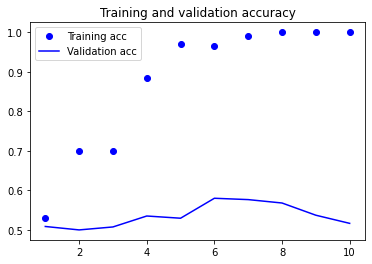

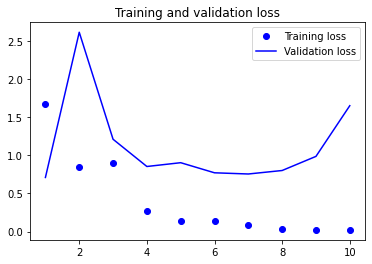

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

이 모델은 검증 정확도가 50% 후반이며 과대적합이 빠르게 시작됩니다. 훈련 샘플수가 작기 때문입니다.

[과제] 사전 훈련된 임베딩을 사용하지 않고 상기 작업(샘플 200개)을 수행하여 비교해 보세요.

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 242ms/step - loss: 0.6948 - acc: 0.5300 - val_loss: 0.6911 - val_acc: 0.5286
Epoch 2/10
7/7 [==============================

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))


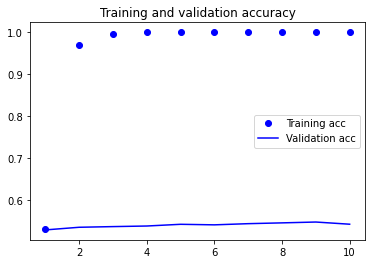

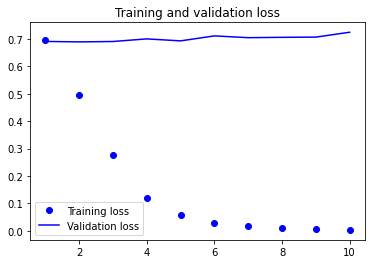

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# val 정확도가 거의 상승하지 않는다.

[과제] 상기 과제를 훈련샘플 2000개로 늘려서 모델링 및 시각화 수행하여 상기 경우와 비교해 보세요.

In [ ]:
training_samples = 2000
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                320032    
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
63/63 [==============================] - 2s 15ms/step - loss: 0.9944 - acc: 0.5350 - val_loss: 1.0430 - val_acc: 0.5107
Epoch 2/10
63/63 [==============================] - 1s 13ms/step - loss: 0.7895 - acc: 0.6245 - val_loss: 0.6846 - val_acc: 0.6319
Epoch 3/10
63/63 [==============================] - 1s 13ms/step - loss: 0.6741 - acc: 0.6990 - val_loss: 1.2543 - val_acc: 0.5311
Epoch 4/10
63/63 [==============================] - 1s 12ms/step - loss: 0.4910 - acc: 0.7905 - val_loss: 0.7661 - val_acc: 0.6253
Epoch 5/10
63/63 [==============================] - 1s 13ms/step - loss: 0.3820 - acc: 0.8320 - val_loss: 1.3011 - val_acc: 0.5489
Epoch 6/10
63/63 [==============================] - 1s 13ms/step - loss: 0.2930 - acc: 0.8770 - val_loss: 0.7557 - val_acc: 0.6489
Epoch 7/10
63/63 [==============================] - 1s 13ms/step - loss: 0.2536 - acc: 0.9010 - val_loss: 1.1250 - val_acc: 0.5915
Epoch 8/10
63/63 [==============================] - 1s 13ms/step - loss: 0.1834 - a

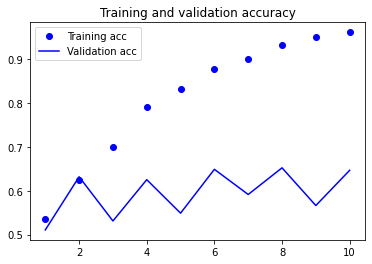

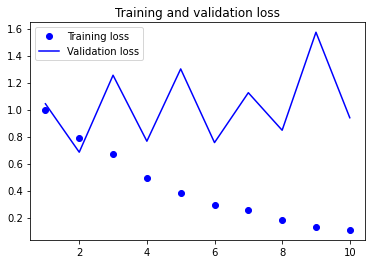

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# 정확도가 조금 더 늘긴 했지만 불안정하다

단어 임베딩 : Word2Vec

https://doc.mindscale.kr/km/unstructured/11.html

[과제] 'https://www.gutenberg.org/files/2591/2591-0.txt' The Project Gutenberg 사이트 텍스트를 전처리 후 다음을 수행하세요.
- 사전 훈련된 Word2Vec을 gensim을 이용하여 임포트 후 cbow, skip-gram 방식으로 모델링하여 유사도 측정
  - wv.similarity('king','prince')
  - wv.most_similar('king')
  - most_similar(positive=['man','princess'], negative=['woman'])
- 옵션 사항
  - size(워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원) : 100
  - window(컨텍스트 윈도우 크기) : 3
  - min_count(단어 최소 빈도 수 제한-빈도가 적은 단어들은 학습하지 않는다.) : 3
  - workers(학습을 위한 프로세스 수) : 4
  - sg = 0은 CBOW, 1은 Skip-gram.


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_stopwords(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w not in stop_words and len(w) > 3])

In [27]:
res = requests.get('https://www.gutenberg.org/files/2591/2591-0.txt')
res.text

'ï»¿The Project Gutenberg eBook of Grimmsâ\x80\x99 Fairy Tales, by Jacob Grimm and Wilhelm Grimm\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this eBook or online at\r\nwww.gutenberg.org. If you are not located in the United States, you\r\nwill have to check the laws of the country where you are located before\r\nusing this eBook.\r\n\r\nTitle: Grimmsâ\x80\x99 Fairy Tales\r\n\r\nAuthor: Jacob Grimm and Wilhelm Grimm\r\n\r\nTranslators: Edgar Taylor and Marian Edwardes\r\n\r\nRelease Date: April, 2001 [eBook #2591]\r\n[Most recently updated: June 28, 2021]\r\n\r\nLanguage: English\r\n\r\nCharacter set encoding: UTF-8\r\n\r\nProduced by: Emma Dudding, John Bickers, Dagny and David Widger\r\n\r\n*** START OF THE PROJECT GUTENBERG EBOOK GRIMMSâ\x80\x99 FAIRY TAL

In [28]:
len(res.text)

560045

In [29]:
len(data)

3154

In [16]:
import requests
import re

res = requests.get('https://www.gutenberg.org/files/2591/2591-0.txt')

# 앞과 뒤에서 불필요한 부분을 완전 제외한다.
grimm = res.text[2801:530661]

# 정규표현식을 이용하여 불필요한 단어는 제외한다.
grimm = re.sub(r'[^a-zA-Z\. ]', ' ', grimm)

# stopwords 제거
grimm = clean_stopwords(grimm)

# .split('. ')을 이용하여 마침표 단위로 자르기.
sentences = grimm.split('. ')  # 문장 단위로 자름

# 단어(빈칸) 단위로 자르기
data = [s.split() for s in sentences]

data[0] 

['second',
 'story',
 'salad',
 'story',
 'youth',
 'went',
 'forth',
 'learn',
 'what',
 'fear',
 'king',
 'grisly',
 'beard',
 'iron',
 'hans',
 'skin',
 'snow',
 'white',
 'rose',
 'brothers',
 'grimm',
 'fairy',
 'tales',
 'golden',
 'bird',
 'certain',
 'king',
 'beautiful',
 'garden',
 'garden',
 'stood',
 'tree',
 'bore',
 'golden',
 'apples']

In [17]:
from gensim.models.word2vec import Word2Vec

In [18]:
model_cb = Word2Vec(data,         # 리스트 형태의 데이터
                 sg=0,         # 0: CBOW, 1: Skip-gram
                 size=100,     # 벡터 크기
                 window=3,     # 고려할 앞뒤 폭(앞뒤 3단어)
                 min_count=3,  # 사용할 단어의 최소 빈도(3회 이하 단어 무시)
                 workers=4)    # 동시에 처리할 작업 수(코어 수와 비슷하게 설정)
model_cb.save('/content/drive/MyDrive/Colab Notebooks/m9_딥러닝알고리즘구현/model_saves/word2vec_CBOW.model')

In [19]:
model_sg = Word2Vec(data,         # 리스트 형태의 데이터
                 sg=1,         # 0: CBOW, 1: Skip-gram
                 size=100,     # 벡터 크기
                 window=3,     # 고려할 앞뒤 폭(앞뒤 3단어)
                 min_count=3,  # 사용할 단어의 최소 빈도(3회 이하 단어 무시)
                 workers=4)    # 동시에 처리할 작업 수(코어 수와 비슷하게 설정)
model_sg.save('/content/drive/MyDrive/Colab Notebooks/m9_딥러닝알고리즘구현/model_saves/word2vec_Skip-gram.model')

In [20]:
model_cb.wv.similarity('king','prince')

0.99984926

In [21]:
model_sg.wv.similarity('king','prince')

0.9990397

In [22]:
model_cb.wv.most_similar('king')

[('would', 0.9999274015426636),
 ('cried', 0.9999250173568726),
 ('made', 0.9999197721481323),
 ('still', 0.9999182820320129),
 ('away', 0.9999173283576965),
 ('like', 0.9999170303344727),
 ('little', 0.9999163150787354),
 ('could', 0.9999155402183533),
 ('tree', 0.9999139308929443),
 ('time', 0.9999139308929443)]

In [23]:
model_sg.wv.most_similar('king')

[('would', 0.9991563558578491),
 ('goose', 0.9991068840026855),
 ('unless', 0.9990811944007874),
 ('you', 0.9990620613098145),
 ('forth', 0.9990589618682861),
 ('prince', 0.9990396499633789),
 ('pope', 0.9990367889404297),
 ('false', 0.9990322589874268),
 ('huntsmen', 0.9990159273147583),
 ('tomorrow', 0.9990149140357971)]

In [24]:
model_cb.most_similar(positive=['man','princess'], negative=['woman'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('merry', 0.9953442811965942),
 ('learnt', 0.9953340888023376),
 ('forced', 0.9952875375747681),
 ('wished', 0.9952406287193298),
 ('girl', 0.9952110052108765),
 ('kitchen', 0.9951977729797363),
 ('drank', 0.9951881170272827),
 ('middle', 0.9951848983764648),
 ('already', 0.9951797723770142),
 ('dear', 0.9951790571212769)]

In [25]:
model_sg.most_similar(positive=['man','princess'], negative=['woman'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('feel', 0.9989070892333984),
 ('merry', 0.9989067316055298),
 ('begged', 0.9988993406295776),
 ('sisters', 0.9988888502120972),
 ('doctor', 0.9988566637039185),
 ('wished', 0.9988498687744141),
 ('happened', 0.9988483786582947),
 ('frog', 0.9988425970077515),
 ('followed', 0.9988408088684082),
 ('whatever', 0.9988390207290649)]

In [ ]:
from sklearn import datasets
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state = 100,
                             remove = ('headers','footers','quotes'))

documents = dataset.data
print(len(documents))
documents[3]

11314


"How long can the Leafs play short-handed and still be expected to\nscore?  They did some fine penely-killing in the first (2 men down\nfor a couple of minutes at one point) but they just couldn't keep it \nup.  They spent virtually the entire game either short-handed or\njust coming off a penelty -- as soon as they'd get re-grouped, they're\npenalized again!\n \nSheesh -- like Gilmour said after the 1st -- you can't go calling \nevery little push an shove in a game like that.  And if you're going\nto, you have to do it for both teams.\n \nPearson (one of my four favorite Leafs) played like a bonehead -- I\nsaw him personally screw up at least 2 good scoring opportunities, and\nthen he got that *bonehead* 5-minute major high-sticking penalty.\n \nCullen has gotten stronger since his return from injury a hand-full of\ngames ago and he played a good game.  If the other players on his line\ncan smarten up, that line should do okay.  Clark's got to get tough --\nhe's got to intimidate and 

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]'
  d = re.sub(pattern,'',d)
  return d

def clean_stopwords(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w not in stop_words and len(w) > 3])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import pandas as pd
news_df = pd.DataFrame({'article':documents})
len(news_df)

11314

In [ ]:
news_df.replace('',float('Nan'),inplace = True)
news_df.dropna(inplace=True)
len(news_df)

11096

In [ ]:
news_df['article'] =  news_df['article'].apply(clean_text)
news_df['article']

0        \n\n\n\n\nI sold my  Sprint last April with k ...
1        \n\n\nWhat do you find so wrong with the flat ...
2        Just as the title suggest is it okay to do tha...
3        How long can the Leafs play shorthanded and st...
4        \nduh why not just chop out the sig\n\nbob ves...
                               ...                        
11309    \n\n\nGregs obviously confused There arent man...
11310    If anyone has Joe Venutis record Fiddle on Fir...
11311    \n\nWe have plenty of computer labs where the ...
11312    \nSo whats your point  Marks comment still is ...
11313    \nIn fact you probably want to avoid US Govern...
Name: article, Length: 11096, dtype: object

In [ ]:
news_df['article'] =  news_df['article'].apply(clean_stopwords)
news_df['article']

0        sold sprint last april driven since previous j...
1                 what find wrong flat subarus flat matter
2        just title suggest okay havnet heart doublespa...
3        long leafs play shorthanded still expected sco...
4        chop vesterman kids take pictures dead preside...
                               ...                        
11309    gregs obviously confused there arent many gent...
11310    anyone venutis record fiddle fire would like s...
11311    plenty computer labs computers left time dont ...
11312    whats point marks comment still valid suggest ...
11313    fact probably want avoid government anything p...
Name: article, Length: 11096, dtype: object

In [ ]:
tokenized_news =  news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()
tokenized_news[16]

[]

In [ ]:
len(tokenized_news)

11096

In [ ]:
drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
drop_news

[13,
 16,
 193,
 411,
 493,
 512,
 553,
 666,
 721,
 963,
 964,
 1019,
 1093,
 1252,
 1415,
 1498,
 1518,
 1606,
 1621,
 1647,
 1898,
 1918,
 1924,
 1959,
 2016,
 2055,
 2091,
 2101,
 2112,
 2344,
 2382,
 2383,
 2414,
 2439,
 2522,
 2554,
 2566,
 2599,
 2628,
 2744,
 2791,
 2876,
 2888,
 2953,
 2956,
 2990,
 3070,
 3089,
 3174,
 3179,
 3229,
 3233,
 3343,
 3365,
 3475,
 3486,
 3566,
 3764,
 3991,
 4091,
 4203,
 4219,
 4330,
 4365,
 4476,
 4523,
 4549,
 4552,
 4697,
 4791,
 4975,
 4983,
 5091,
 5151,
 5302,
 5366,
 5486,
 5566,
 5574,
 5722,
 5886,
 5903,
 5908,
 5913,
 6099,
 6191,
 6241,
 6447,
 6469,
 6557,
 6562,
 6621,
 6766,
 6779,
 6829,
 6862,
 7213,
 7460,
 7506,
 7512,
 7531,
 7630,
 7851,
 7904,
 7940,
 7998,
 8112,
 8147,
 8228,
 8262,
 8271,
 8404,
 8413,
 8421,
 8425,
 8441,
 8470,
 8478,
 8515,
 8618,
 8662,
 8705,
 8778,
 8795,
 8863,
 9010,
 9107,
 9183,
 9307,
 9330,
 9361,
 9391,
 9437,
 9551,
 9557,
 9590,
 9606,
 9813,
 9896,
 10008,
 10080,
 10139,
 10178,
 10288,


In [ ]:
import numpy as np
news_texts = np.delete(tokenized_news,drop_news,axis=0)
print(len(news_texts))

10945


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
# CBOW

from gensim.models import Word2Vec

model = Word2Vec(sentences = news_texts,         # 리스트 형태의 데이터
                 window = 4,   # 고려할 앞뒤 폭(앞뒤 4단어)
                 size = 100,     # 벡터 크기  
                 min_count = 5,  # 사용할 단어의 최소 빈도(3회 이하 단어 무시)
                 workers = 4,    # 동시에 처리할 작업 수(코어 수와 비슷하게 설정)
                 sg=0)         # 0: CBOW, 1: Skip-gram

In [ ]:
model.wv.similarity('king','queen')

0.9419946

In [ ]:
model.most_similar(positive=['soldiers'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('land', 0.9882300496101379),
 ('henrik', 0.9860848188400269),
 ('nagarnokarabagh', 0.9854251146316528),
 ('turks', 0.9849645495414734),
 ('turkey', 0.9828783273696899),
 ('killed', 0.9793784022331238),
 ('muslim', 0.9788150787353516),
 ('armenians', 0.9768950939178467),
 ('died', 0.9744945168495178),
 ('azerbaijani', 0.9718830585479736)]

In [ ]:
model.wv.most_similar(positive=['tiger','cats'],negative=['wolves'])

[('insane', 0.9954069256782532),
 ('repeat', 0.9952848553657532),
 ('wasted', 0.9951066970825195),
 ('knock', 0.9947565793991089),
 ('upset', 0.9947023391723633),
 ('having', 0.9942803382873535),
 ('boss', 0.9937737584114075),
 ('surprise', 0.9936223030090332),
 ('jump', 0.9934046864509583),
 ('insisted', 0.9930770397186279)]

[과제] skip-gram으로 상기 과제를 수행하세요.

In [ ]:
model = Word2Vec(sentences = news_texts,         # 리스트 형태의 데이터
                 window = 4,   # 고려할 앞뒤 폭(앞뒤 4단어)
                 size = 100,     # 벡터 크기  
                 min_count = 5,  # 사용할 단어의 최소 빈도(3회 이하 단어 무시)
                 workers = 4,    # 동시에 처리할 작업 수(코어 수와 비슷하게 설정)
                 sg=1)         # 0: CBOW, 1: Skip-gram

In [ ]:
model.wv.similarity('king','queen')

0.76298857

In [ ]:
model.most_similar(positive=['soldiers'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('wounded', 0.9311781525611877),
 ('azeri', 0.9243040084838867),
 ('troops', 0.9231357574462891),
 ('murdered', 0.9190658926963806),
 ('escaped', 0.9125658273696899),
 ('burned', 0.9122220873832703),
 ('massacre', 0.9117825031280518),
 ('village', 0.9103869199752808),
 ('fighting', 0.9102914929389954),
 ('karabakh', 0.9075201749801636)]

In [ ]:
model.wv.most_similar(positive=['tiger','cats'],negative=['wolves'])

[('impress', 0.9661687612533569),
 ('unload', 0.9657061100006104),
 ('insured', 0.9605430960655212),
 ('reciever', 0.9604462385177612),
 ('merchandise', 0.9590870141983032),
 ('excited', 0.9586925506591797),
 ('punch', 0.9582531452178955),
 ('volvos', 0.9575545787811279),
 ('favourite', 0.9571229219436646),
 ('hype', 0.9567718505859375)]